In [1]:
import h5py
import numpy as np
import pandas as pd
import sklearn.metrics
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple

In [3]:
sns.reset_defaults()
sns.set_theme(context='paper',style='white',palette=sns.color_palette("bright"),font_scale=1.5,font='serif')


#def image_extraction(filename:str) -> Tuple[np.array, pd.DataFrame]:
#    """Extract images aswell as the foldless dataset. The indeces will match between ds and image array, but not ID."""
#    dataset = h5py.File(filename, 'r')
#    ds = pd.DataFrame()
#    for i, fold in enumerate(dataset.keys()):
#        df=pd.DataFrame({'ID':np.array(dataset[fold]['patient_idx']),'target':np.array(dataset[fold]['y']),'diagnosis':np.array(dataset[fold]['diagnosis']),'fold':i})
#        ds=pd.concat([ds,df],ignore_index=True,axis=0,keys=['','fold {}'.format(fold)]) # ignore index to match index with image indeces
#    #ds.set_index("ID", inplace = True)
#    images=np.array(dataset['fold_0']['x'])
#    images = np.append(images,np.array(dataset['fold_1']['x']),axis=0)
#    images=np.append(images,np.array(dataset['fold_2']['x']),axis=0)
#    images=np.append(images,np.array(dataset['fold_3']['x']),axis=0)
#    images=np.append(images,np.array(dataset['fold_4']['x']),axis=0)
#    images=np.append(images,np.array(dataset['fold_5']['x']),axis=0)
#    images=images.reshape(len(images),800,800)
#    dataset.close()
#    return images, ds

def image_extraction(filename: str) -> Tuple[np.ndarray, pd.DataFrame]:
    """Extract images as well as the foldless dataset. The indices will match between ds and image array, but not ID."""
    with h5py.File(filename, 'r') as dataset:
        ds = pd.DataFrame()
        images = []

        for i, fold in enumerate(dataset.keys()):
            # Accessing datasets directly
            patient_idx = np.array(dataset[fold]['patient_idx'])
            target = np.array(dataset[fold]['target'])
            diagnosis = np.array(dataset[fold]['diagnosis'])
            fold_images = np.array(dataset[fold]['image'])

            # Building the DataFrame
            df = pd.DataFrame({'ID': patient_idx, 'target': target, 'diagnosis': diagnosis, 'fold': i})
            ds = pd.concat([ds, df], ignore_index=True)

            # Append images
            images.append(fold_images)

        # Concatenating all images from all folds
        images = np.concatenate(images, axis=0)
        images = images.reshape(len(images), 800, 800)

        return images, ds

def test_result_extraction(filename):
    """Make dataframe of prediction."""
    f = h5py.File(filename, 'r')
    pred = np.array(f['predicted'][:])
    patient = np.array(f['patient_idx'][:])
    y = np.array(f['y'][:]).argmax(axis=1)
    f.close()

    df = pd.DataFrame({'pred':pred.argmax(axis=1),'label': y},index=patient)

    df['prob']=np.round(np.round(pred.max(axis=1),2),2)
    df['pred']=np.round(df['pred'],0)
    df['label']=df['label']
    return df
       
def check_wrong(df, show_images=True, original_dataset=None, images=None):
    """
    df: the .h5 file of the test result
    """
    diagnoses=['normal','1, artrose/ sklerose','2, artrose', '2, MCD',
               '3, artrose', '3, MCD', '3, OCD', '3, UAP']
    wrong=df.iloc[np.where(df['pred'].values!=df['label'])[0]].index

    cm=sklearn.metrics.ConfusionMatrixDisplay.from_predictions(df['pred'],df['label'],normalize='true');
    plt.figure()
    sns.heatmap(cm.confusion_matrix,annot=True)
    plt.xticks([0.5,1.5,2.5,3.5],['Level 0','Level 1','Level 2', 'Level 3'])
    plt.yticks([0.5,1.5,2.5,3.5],['Level 0','Level 1','Level 2', 'Level 3'])
    plt.title('Normalized Confusion Matrix') #(normalisert over sann diagnose)
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    plt.show()

    df['result']= 'Correct'
    df.loc[wrong,('result')] = 'Wrong'
    df_wrong = df[df.result=='Wrong']
    df_wrong.loc[df_wrong.label==0,"label"]="Level 0"
    df_wrong.loc[df_wrong.label==1,"label"]="Level 1"
    df_wrong.loc[df_wrong.label==2,"label"]="Level 2"
    df_wrong.loc[df_wrong.label==3,"label"]="Level 3"

    plt.figure()
    sns.stripplot(data=df_wrong,x='pred',y='prob',jitter=True,hue='label')
    plt.legend(title='True Class',loc='right', bbox_to_anchor=(1.2, 0.2),
            ncol=1, fancybox=True)
    sns.violinplot(x=df_wrong['pred'],y=df_wrong['prob'],color="0.8",scale="count")
    plt.xticks([0,1,2,3],['Level 0','Level 1','Level 2', 'Level 3'])
    plt.xlabel('Predicted Class')
    plt.ylabel('Predicted Probability')
    plt.yticks(np.arange(0.4,1.1,0.2))
    plt.show()

    plt.figure()
    sns.stripplot(data=df[df['result']=='Correct'],x='pred',y='prob',jitter=True,hue='label')
    sns.violinplot(data=df[df['result']=='Correct'],x='pred',y='prob',color="0.8",scale="count")
    plt.xticks([0,1,2,3],['Level 0','Level 1','Level 2', 'Level 3'])
    plt.xlabel('Predicted Class')
    plt.ylabel('Predicted Probability')
    plt.yticks(np.arange(0.4,1.1,0.2))
    plt.legend([],[], frameon=False) # Remove legend, but keep hue colors
    plt.show()

    # plt.figure()
    # plt.title('Prøver feilklassifisert som nivå 1')
    # sns.histplot(df_wrong[df_wrong.pred==0], x='prob', bins=100, hue='label',stat="proportion",palette="dark")
    # plt.show()

    # plt.figure()
    # plt.title('Prøver feilklassifisert som nivå 2')
    # sns.histplot(df_wrong[df_wrong.pred==1], x='prob', bins=100, stat="proportion",hue='label',palette="dark")
    # plt.show()

    # plt.figure()
    # plt.title('Prøver feilklassifisert som nivå 3')
    # sns.histplot(df_wrong[df_wrong.pred==2], x='prob', bins=100, stat="proportion",hue='label')
    # plt.show()
    
    plt.figure()
    plt.title('Correctly Predicted Samples')
    sns.histplot(df[df['result']=='Correct'], x='prob', stat="proportion",bins=100,hue="label",palette="bright")
    plt.show()

    plt.figure()
    sns.histplot(x=df.pred.loc[wrong].astype(str),data=df.loc[wrong],stat="proportion")
    plt.title('Distribution of wrongly predicted classes at each level. \n (how many that got wrongly predicted as level 0, 1, 2 and 3)')
    plt.xticks([0,1,2,3],['Level 0','Level 1','Level 2','Level 3'])
    plt.show()

    plt.figure()
    sns.histplot(x=df.label.loc[wrong].astype(str),data=df.loc[wrong],stat="proportion")
    plt.title('Distribution of wrongly predicted classes at each level. \n (how many from level 0, 1, 2 and 3 that were predicted as something else)')
    plt.xticks([0,1,2,3],['Level 0','Level 1','Level 2','Level 3'])
    plt.show()

    result_list=[]
    for i in wrong:
        if original_dataset is not None:
            result_list.append('ID: {}, prob: {:.2f}, True: {}'.format(original_dataset[original_dataset.ID==i].index[0],
                                                                    df.prob[i],
                                                                    original_dataset.diagnosis[original_dataset.ID==i].values[0]))
        if show_images==True:
            plt.figure()
            plt.imshow(images[original_dataset[original_dataset.ID==i].index[0]],'gray')
            plt.axis('off')
            plt.title('ID: {}, True: {}, Predicted: {:.2f} class {}'.format(original_dataset[original_dataset.ID==i].index[0],
                                                                    diagnoses[int(original_dataset.diagnosis[original_dataset.ID==i].values[0])],
                                                                    df.prob[i],df.pred[i]))
            plt.show()

    return df_wrong

In [7]:
def print_h5_structure(filename: str):
    with h5py.File(filename, 'r') as file:
        def print_structure(name, obj):
            print(name, type(obj))
            if isinstance(obj, h5py.Dataset):
                print(f" - Shape: {obj.shape}, Datatype: {obj.dtype}")
                print(obj[:].sum(axis=0))

        file.visititems(print_structure)

filename = 'S:/Master/cubiai/h5_files/prediction_test.h5'
print_h5_structure(filename)

patient_idx <class 'h5py._hl.dataset.Dataset'>
 - Shape: (2229,), Datatype: int32
5984453
predicted <class 'h5py._hl.dataset.Dataset'>
 - Shape: (2229, 4), Datatype: float32
[2.0619575e+03 1.6801049e-06 3.5475871e-08 1.6704266e+02]
y <class 'h5py._hl.dataset.Dataset'>
 - Shape: (2229, 4), Datatype: float32
[1983.  100.   75.   71.]


In [3]:
#Checking the structure of the h5 file

def explore_h5_file(filename: str):
    with h5py.File(filename, 'r') as file:
        def explore(name, node):
            if isinstance(node, h5py.Dataset):
                print(f"Dataset: {name}, Shape: {node.shape}, Datatype: {node.dtype}")
            else:
                print(f"Group: {name}")

        file.visititems(explore)

filename = 'S:/Master/data/elbow_normal_abnormal_800.h5'
explore_h5_file(filename)

Group: fold_0
Dataset: fold_0/diagnosis, Shape: (1024,), Datatype: float32
Dataset: fold_0/image, Shape: (1024, 800, 800, 1), Datatype: float32
Dataset: fold_0/patient_idx, Shape: (1024,), Datatype: int32
Dataset: fold_0/target, Shape: (1024,), Datatype: float32
Group: fold_1
Dataset: fold_1/diagnosis, Shape: (1024,), Datatype: float32
Dataset: fold_1/image, Shape: (1024, 800, 800, 1), Datatype: float32
Dataset: fold_1/patient_idx, Shape: (1024,), Datatype: int32
Dataset: fold_1/target, Shape: (1024,), Datatype: float32
Group: fold_2
Dataset: fold_2/diagnosis, Shape: (1024,), Datatype: float32
Dataset: fold_2/image, Shape: (1024, 800, 800, 1), Datatype: float32
Dataset: fold_2/patient_idx, Shape: (1024,), Datatype: int32
Dataset: fold_2/target, Shape: (1024,), Datatype: float32
Group: fold_3
Dataset: fold_3/diagnosis, Shape: (1024,), Datatype: float32
Dataset: fold_3/image, Shape: (1024, 800, 800, 1), Datatype: float32
Dataset: fold_3/patient_idx, Shape: (1024,), Datatype: int32
Datase

In [14]:
# images, ds = image_extraction('S:/Master/data/elbow_normal_abnormal_800.h5')
df = test_result_extraction('S:/Master/cubiai/h5_files/b4_001_categorical/prediction_test.h5')

In [15]:
df['result']= 'Correct'
wrong=df.iloc[np.where(df['pred'].values!=df['label'])[0]].index
df.loc[wrong,('result')] = 'Wrong'
df_wrong = df[df.result=='Wrong']
#df_wrong.loc[df_wrong.label==0,"label"]="Nivå 1"
#df_wrong.loc[df_wrong.label==1,"label"]="Nivå 2"
#df_wrong.loc[df_wrong.label==2,"label"]="Nivå 3"

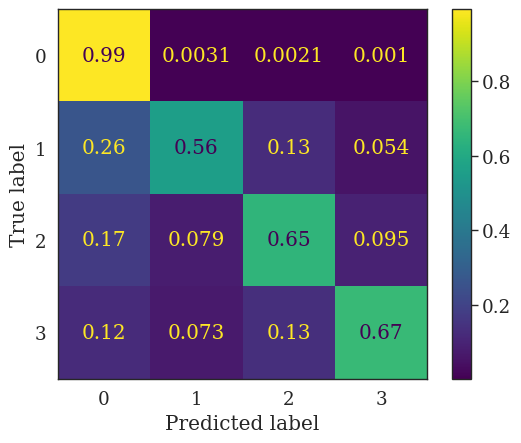

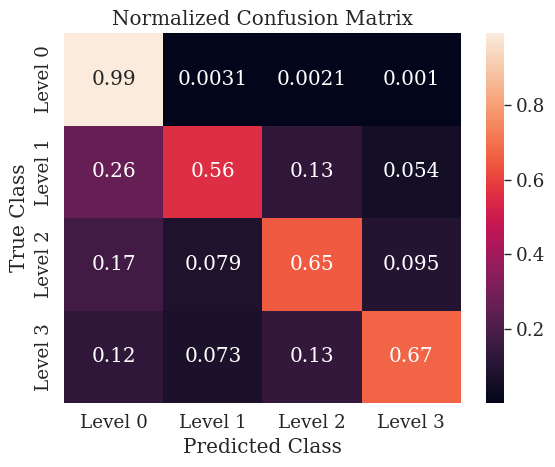

c:\Users\mkrtc\anaconda3\envs\dat450\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


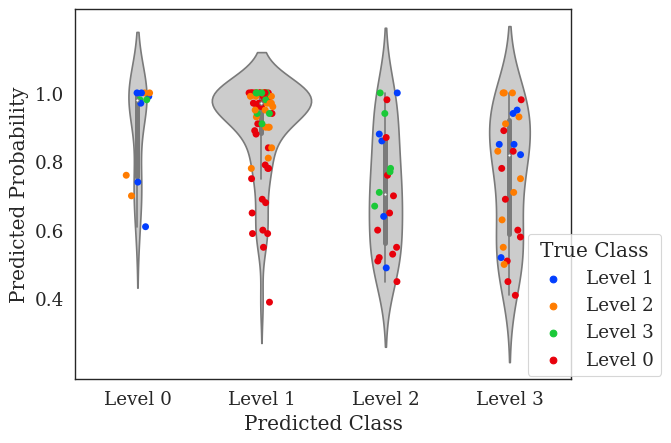

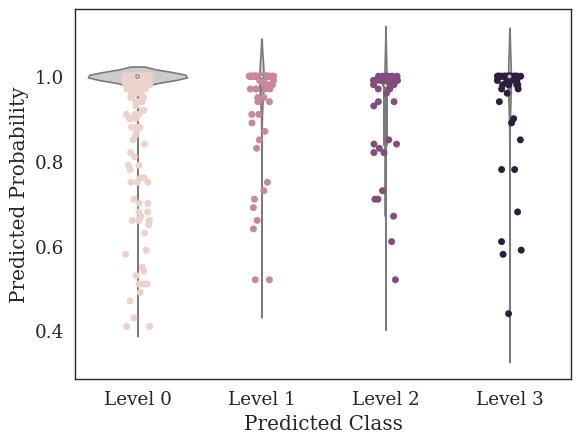

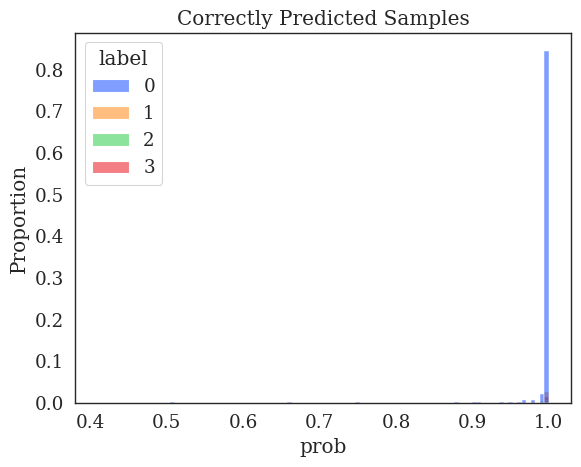

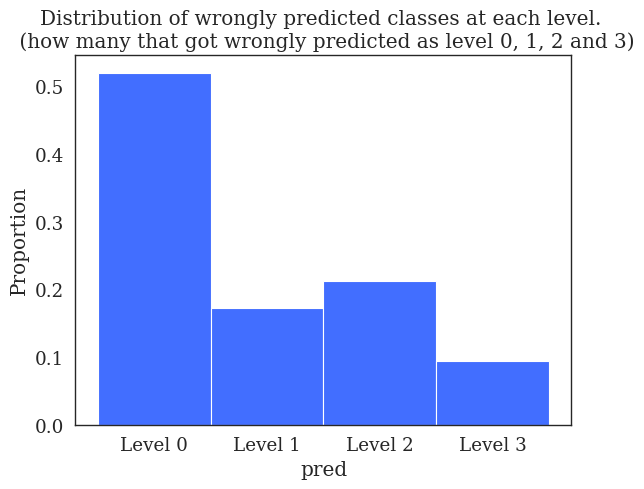

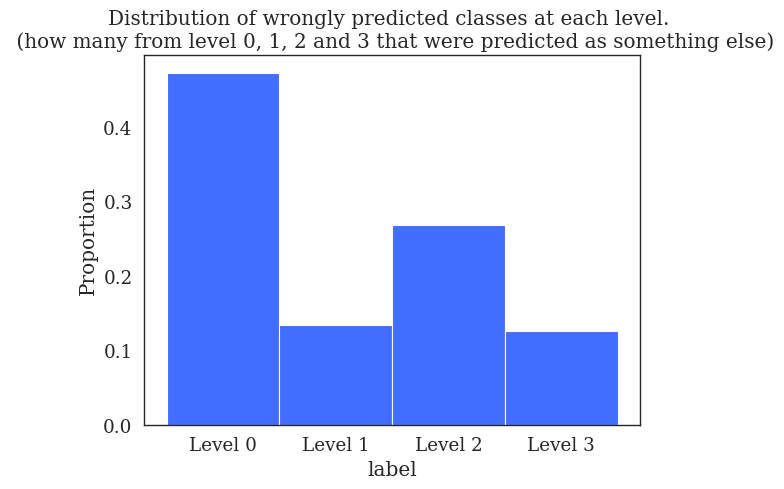

In [16]:
l=check_wrong(df,show_images=False, original_dataset=ds, images=images)